## Importing Libraries:

In [66]:
import h5py
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt


In [67]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Loading and Preprocessing Images:

the load_images_from_folder function is defined to load images from the specified directories and resize them to a uniform size of 128x128 pixels. The images are also labeled based on the subdirectory names, with dogs being assigned a label of 1 and cats a label of 0

In [68]:

# Define the paths to training and test directories
train_dir = '/content/drive/Othercomputers/Mon_MacBook_Pro/training_set'
test_dir = '/content/drive/Othercomputers/Mon_MacBook_Pro/test_set'



def load_images_from_folder(folder, image_size=(128, 128)):
    images = []
    labels = []
    for subdir in os.listdir(folder):
        label = 1 if subdir == 'dogs' else 0
        for filename in os.listdir(os.path.join(folder, subdir)):
            img_path = os.path.join(folder, subdir, filename)
            img = cv2.imread(img_path)
            img = cv2.resize(img, image_size)  
            if img is not None:
                images.append(img)
                labels.append(label)  # Use 1 for dogs and 0 for cats
    return images, labels


train_images, train_labels = load_images_from_folder(train_dir)
test_images, test_labels = load_images_from_folder(test_dir)

The plot_images function is defined to visualize the loaded images in a 3x3 grid for both dogs and cats.

In [69]:

def plot_images(images, title):
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))  
    axes = axes.ravel()  

    for i in range(9):  # Display the first 9 images
        axes[i].imshow(images[i], cmap='gray') 
        axes[i].axis('off') 

    plt.suptitle(title)  # Add a title to the plot
    plt.tight_layout()  
    plt.show() 

# Separate the dog and cat images
dog_images = [img for img, label in zip(train_images, train_labels) if label == 1]
cat_images = [img for img, label in zip(train_images, train_labels) if label == 0]


### Plot the dog images


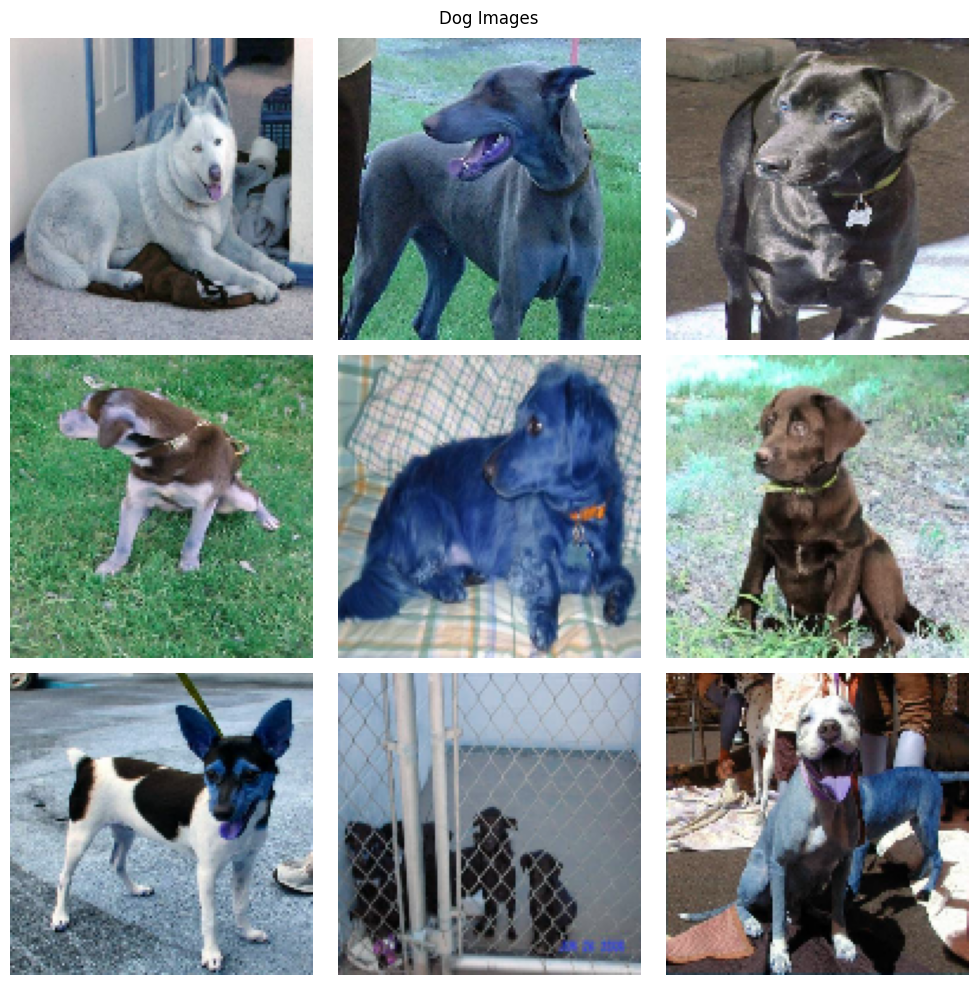

In [70]:
plot_images(dog_images, 'Dog Images')

### Plot the dog images


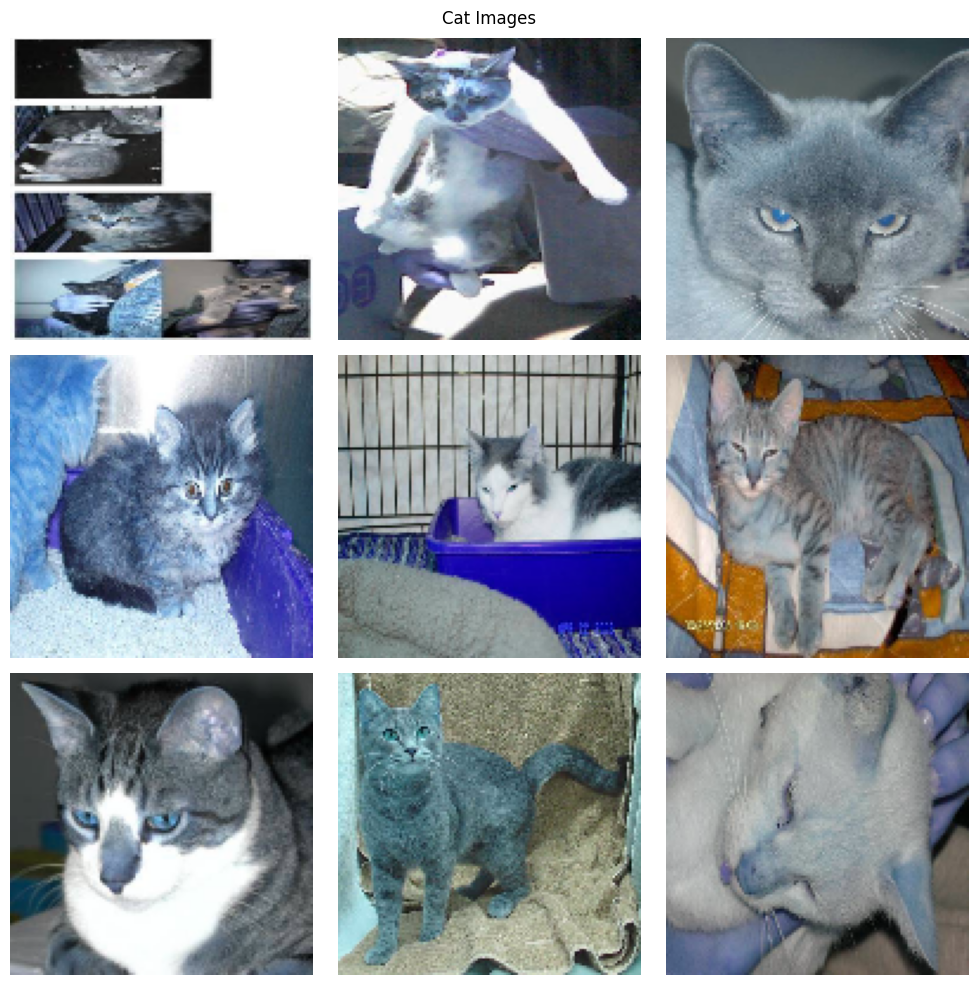

In [ ]:
plot_images(cat_images, 'Cat Images')

In [72]:
train_images = np.array(train_images, dtype='uint8')
train_labels = np.array(train_labels, dtype='uint8')
test_images = np.array(test_images, dtype='uint8')
test_labels = np.array(test_labels, dtype='uint8')
print('train_images shape :', train_images.shape)
print('test_images shape :', test_images.shape)

train_images shape : (4002, 128, 128, 3)
test_images shape : (1012, 128, 128, 3)


In [73]:

# Save to HDF5 files
with h5py.File('trainset.hdf5', 'w') as f:
    f.create_dataset('X_train', data=train_images)
    f.create_dataset('Y_train', data=train_labels)

with h5py.File('testset.hdf5', 'w') as f:
    f.create_dataset('X_test', data=test_images)
    f.create_dataset('Y_test', data=test_labels)

## Model Configuration and Training:

In [74]:
# Model configuration
batch_size = 50
img_width, img_height, img_num_channels = 128, 128, 3
loss_function = sparse_categorical_crossentropy
no_classes = 2
no_epochs = 30
optimizer = Adam()
validation_split = 0.2
verbosity = 1

In [75]:
# Load data
f = h5py.File('trainset.hdf5', 'r')
input_train = f['X_train'][...]
label_train = f['Y_train'][...]
f.close()
f = h5py.File('testset.hdf5', 'r')
input_test = f['X_test'][...]
label_test = f['Y_test'][...]
f.close()

In [76]:
# Reshape data
input_train = input_train.reshape((len(input_train), img_width, img_height, img_num_channels))
input_test  = input_test.reshape((len(input_test), img_width, img_height, img_num_channels))

# Determine shape of the data
input_shape = (img_width, img_height, img_num_channels)

In [77]:
# Create the model

models = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu", input_shape=input_shape),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid'),
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid'),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dropout(0.05),
    tf.keras.layers.Dense(units=32, activation ="relu"),
    tf.keras.layers.Dense(units=16, activation ="relu"),
    tf.keras.layers.Dense(2, activation='sigmoid')
])

In [78]:
# Display a model summary
models.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 64, 64, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 64, 64, 32)        9248      
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 32, 32, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 16, 16, 64)       

In [81]:
# Compile the model
models.compile(loss=loss_function,
              optimizer=optimizer,
              metrics=['accuracy'])

In [82]:
history_test = models.fit(input_train , label_train,
            batch_size=batch_size,
            epochs=30,
            verbose=verbosity,
            validation_split=validation_split)

Epoch 1/30
65/65 [==============================] - 87s 1s/step - loss: 2.6135 - accuracy: 0.5986 - val_loss: 0.8258 - val_accuracy: 0.0437
Epoch 2/30
65/65 [==============================] - 84s 1s/step - loss: 0.6360 - accuracy: 0.6426 - val_loss: 1.2528 - val_accuracy: 0.0337
Epoch 3/30
65/65 [==============================] - 86s 1s/step - loss: 0.5768 - accuracy: 0.6898 - val_loss: 0.8636 - val_accuracy: 0.4432
Epoch 4/30
65/65 [==============================] - 88s 1s/step - loss: 0.5365 - accuracy: 0.7254 - val_loss: 1.6981 - val_accuracy: 0.0637
Epoch 5/30
65/65 [==============================] - 85s 1s/step - loss: 0.5099 - accuracy: 0.7498 - val_loss: 1.1404 - val_accuracy: 0.3059
Epoch 6/30
65/65 [==============================] - 80s 1s/step - loss: 0.4166 - accuracy: 0.8013 - val_loss: 1.0565 - val_accuracy: 0.4444
Epoch 7/30
65/65 [==============================] - 83s 1s/step - loss: 0.3643 - accuracy: 0.8388 - val_loss: 2.0760 - val_accuracy: 0.2597
Epoch 8/30
65/65 [==

In [83]:
# Generate generalization metrics
score = models.evaluate(input_test, label_test, verbose=0)
print(f'test loss: {score[0]} / test accuracy: {score[1]}')

test loss: 2.479179620742798 / test accuracy: 0.6501976251602173


## Visualization of test History:

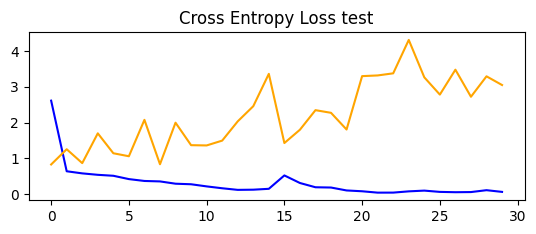

In [84]:
plt.subplot(211)
plt.title('Cross Entropy Loss test')
plt.plot(history_test.history['loss'], color='blue', label='train')
plt.plot(history_test.history['val_loss'], color='orange', label='test')

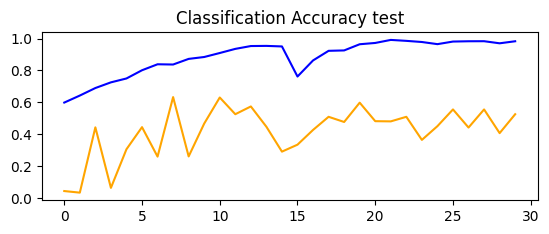

In [85]:
# plot accuracy
plt.subplot(212)
plt.title('Classification Accuracy test')
plt.plot(history_test.history['accuracy'], color='blue', label='train')
plt.plot(history_test.history['val_accuracy'], color='orange', label='test')
# save plot to file
#filename = sys.argv[0].split('/')[-1]
#pyplot.savefig(filename + '_plot.png')
#plt.close()